# An implementation of the online Hidden Markov model with Gaussian observation model

In this notebook, we build the online hidden-Markov model (HMM) from a Bayesian perspective for
regime detection and prediction

In [1]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# Configure matplotlib for publication-quality figures with TeX
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7, 3.0)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

sns.set_palette("colorblind")

In [3]:
key = jax.random.PRNGKey(314) # 314
key_sample, key_run = jax.random.split(key)

(Hidden definition of new macros)
$\newcommand{\vP}{\boldsymbol P}$
$\newcommand{\d}{\rm d}$

# The data generating process

In [4]:
n_regimes = 3
transition_matrix_diag = jnp.ones(n_regimes) * 0.99
transition_matrix = jnp.ones((n_regimes, n_regimes)) * (1 - transition_matrix_diag) / (n_regimes - 1)
transition_matrix =transition_matrix.at[jnp.diag_indices(n_regimes)].set(transition_matrix_diag)

log_transition_matrix = jnp.log(transition_matrix)
means = jnp.array([-1, 0, 1]) * 2
n_regimes = len(means)

In [5]:
transition_matrix

Array([[0.99 , 0.005, 0.005],
       [0.005, 0.99 , 0.005],
       [0.005, 0.005, 0.99 ]], dtype=float32)

In [6]:
obs_var = 1 ** 2

def step(state, key):
    key_state, key_noise = jax.random.split(key)
    proba_change = transition_matrix[state]
    state_next = jax.random.choice(key, len(proba_change), p=proba_change)

    err = jax.random.normal(key_noise) * jnp.sqrt(obs_var)
    obs = means[state_next] + err

    return state_next, (state_next, obs)

In [7]:
state_init = 0
n_steps = 1500
timesteps = jnp.arange(n_steps)

keys = jax.random.split(key_sample, n_steps)
_, (states, obs) = jax.lax.scan(step, state_init, keys)

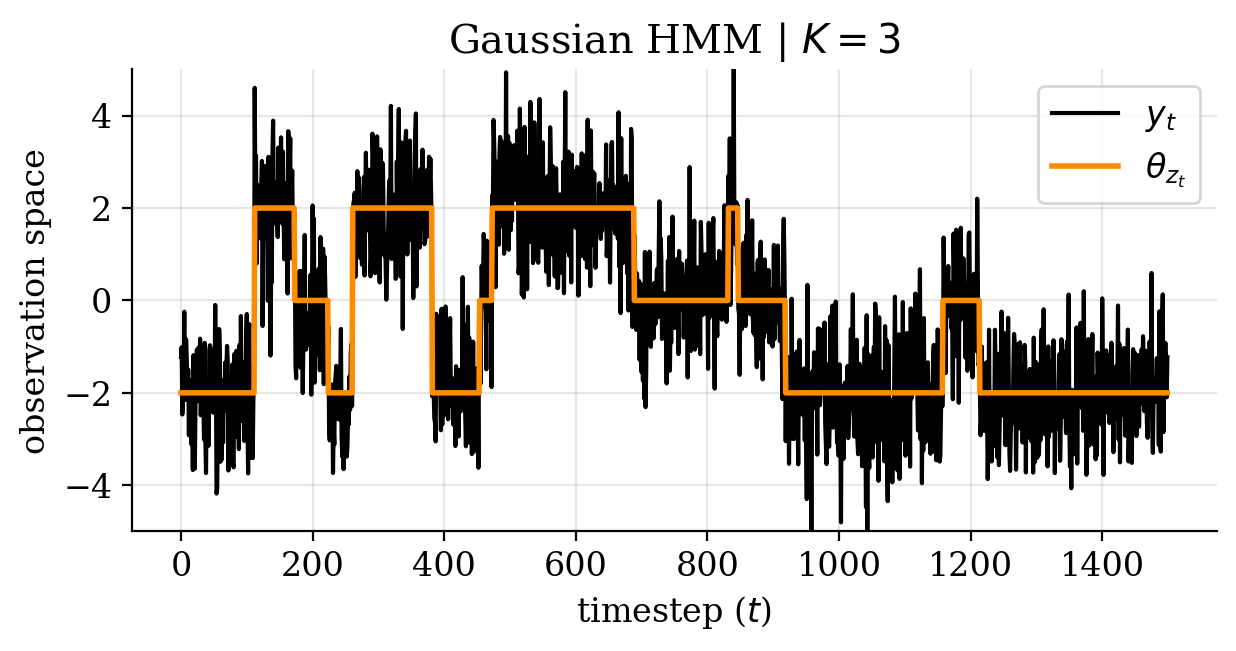

In [8]:
plt.plot(obs, c="black", label="$y_t$")
plt.plot(means.at[states].get(), c="darkorange", linewidth=2, label=r"$\theta_{z_t}$")
plt.xlabel("timestep ($t$)")
plt.ylabel("observation space")
plt.title("Gaussian HMM | $K=3$")
plt.legend()
plt.ylim(-5, 5)
plt.grid(alpha=0.3)
plt.savefig("./figures/hmm-sample-k3.png", dpi=300, bbox_inches="tight")

## Updating beliefs with known regimes

In [22]:
@chex.dataclass
class BeliefRegimes:
    means: chex.Array
    variances: chex.Array

In [23]:
def update(y, mean, var, sigma2):
    """
    Make an update to the one-dimensional
    Gaussian-Gaussian model.
    """
    err = y - mean
    kt = var / (var + sigma2)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    return mean_update, var_update


def update_conditional(bel, xs, sigma2):
    y, z = xs
    mean = bel.means[z]
    var = bel.variances[z]

    mean_update, var_update = update(y, mean, var, sigma2)

    bel_update = bel.replace(
        means=bel.means.at[z].set(mean_update),
        variances=bel.variances.at[z].set(var_update)
    )

    return bel_update, bel

### Experiment

In [31]:
bel_init = BeliefRegimes(means=jnp.zeros(n_regimes), variances=jnp.ones(n_regimes))
bel_final, bel_hist = jax.lax.scan(partial(update_conditional, sigma2=obs_var), bel_init, (obs, states))

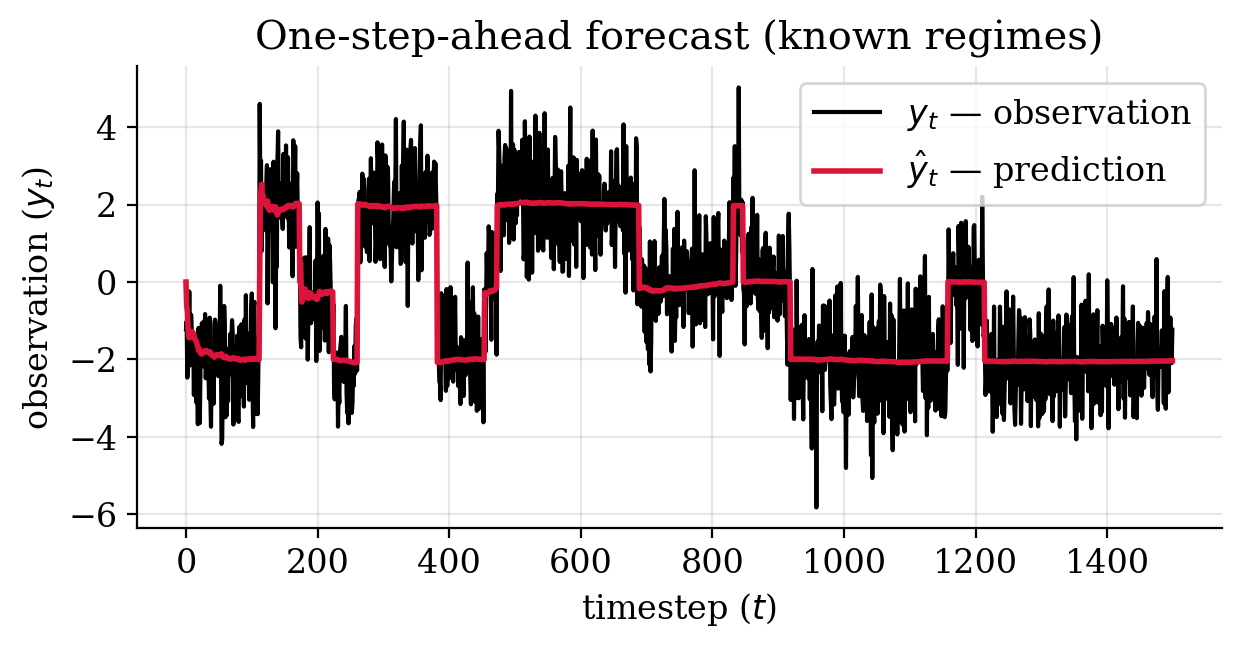

In [32]:
hist_preds = jnp.take_along_axis(bel_hist.means, states[:, None], axis=1)

plt.plot(obs, label="$y_t$ — observation", color="black")
plt.plot(hist_preds, label=r"$\hat{y}_t$ — prediction", linewidth=2, color="crimson")
plt.title("One-step-ahead forecast (known regimes)")
plt.xlabel("timestep ($t$)")
plt.ylabel("observation ($y_t$)")
plt.legend()
plt.grid(alpha=0.3)

## Regime identification (known model parameters)

In [33]:
obs_std = jnp.sqrt(obs_var)

In [34]:
@chex.dataclass
class HMMDetector:
    regimes: chex.Array
    log_weights: chex.Array

# Every regime is paired with a log_weight
@partial(jax.vmap, in_axes=(0, 0, None))
def update_log_weight(regime, log_weight, obs):
    log_transition = log_transition_matrix[regime]
    log_likelihoods = jax.scipy.stats.norm.logpdf(obs, means, obs_std)
    
    log_weight_new = log_weight + log_transition + log_likelihoods
    return log_weight_new


def step(bel, obs):
    log_weights_update = update_log_weight(bel.regimes, bel.log_weights, obs)
    log_weights_update = log_weights_update.ravel()

    ixs = jnp.argsort(log_weights_update, descending=True)[:S]
    regimes_new = ixs % n_regimes
    log_weights_new = log_weights_update[ixs]

    log_weights_new = log_weights_new - jax.nn.logsumexp(log_weights_new)

    bel = bel.replace(
        regimes=regimes_new,
        log_weights=log_weights_new
    )
    return bel, (regimes_new, log_weights_new)

#### Experiment

In [35]:
S = 10
log_weights = jnp.zeros(S)
key_init, key_eval = jax.random.split(key)
regimes = jax.random.choice(key_init, n_regimes, (S,)) # initial regimes

bel = HMMDetector(
    regimes=regimes,
    log_weights=log_weights
)

bel_final, (hist_regimes, hist_log_weights) = jax.lax.scan(step, bel, obs)

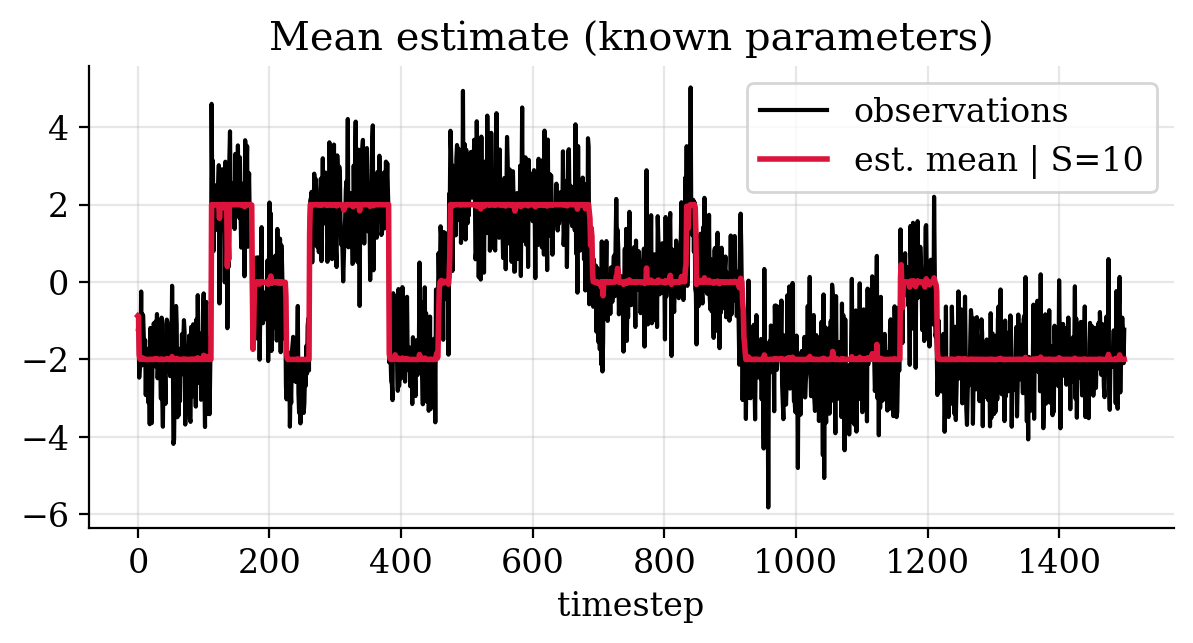

In [36]:
e_mean = (means.at[hist_regimes].get() * jnp.exp(hist_log_weights)).sum(axis=1)

plt.plot(obs, c="black", label="observations")
plt.plot(e_mean, c="crimson", linewidth=2, label=f"est. mean | {S=}")
plt.legend()
plt.xlabel("timestep")
plt.title("Mean estimate (known parameters)")
plt.grid(alpha=0.3)

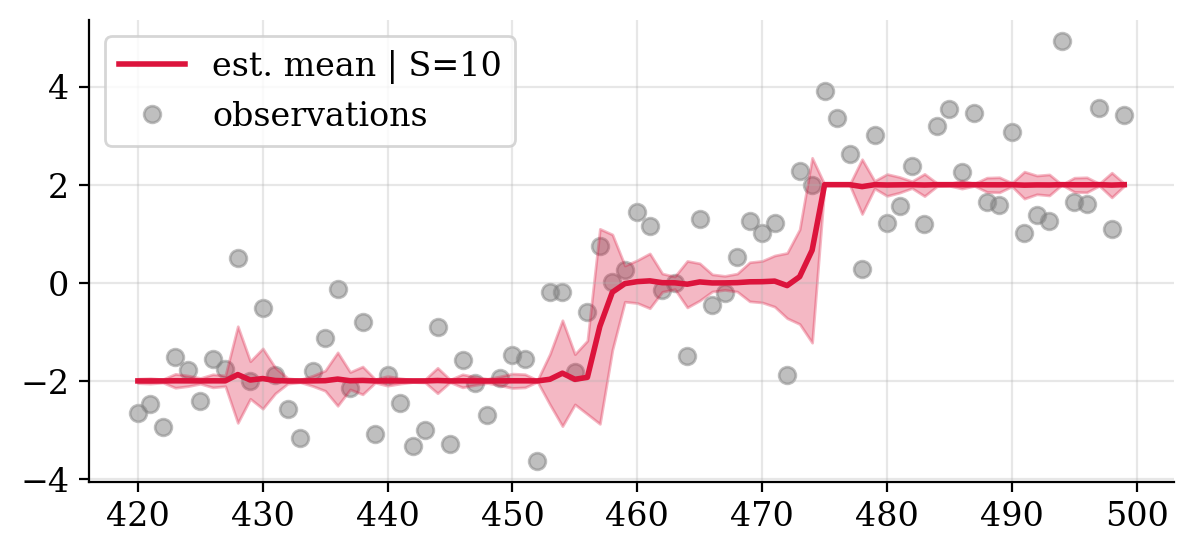

In [37]:
e2_mean = (means.at[hist_regimes].get() ** 2 * jnp.exp(hist_log_weights)).sum(axis=1)
est_std = jnp.sqrt(e2_mean - e_mean ** 2)

lbound = e_mean - 2 * est_std
ubound = e_mean + 2 * est_std
timesteps = jnp.arange(n_steps)
tslice = slice(420, 500)
plt.fill_between(timesteps[tslice], lbound[tslice], ubound[tslice], color="crimson", alpha=0.3)
plt.plot(timesteps[tslice], e_mean[tslice], c="crimson", linewidth=2, label=f"est. mean | {S=}")
plt.plot(timesteps[tslice], obs[tslice], zorder=0, c="gray", alpha=0.5, marker="o", linewidth=0, label="observations")
plt.legend()
plt.grid(alpha=0.3)

---

# Streaming Hidden Markov Model

Here, we assume the transition probabilities between latent states are known.
However, we do not know the location of the states and we do not know the mean value for each of the states.

Formally, we consider the following model
$$
\begin{aligned}
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0,\,\sigma_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$
with $\pi_{i,j}$ known for all $i,j$.

Let $\psi_t \in \Psi_t = \{1, 2, \ldots, K\}^t$
be an auxiliary variable denoting the history of regimes visited.

Starting at at a state $s_0 \in \{1, \ldots, K\}$,
the auxiliary variable is defined as $\psi_0 = \{s_0\}$.
After each step, the auxiliary variable is updated as
$\psi_t = \psi_{t-1} \cup \{s_t\}$ and $\psi_{t-1} = \{s_1, \ldots, s_{t-1}\}$

The possible history of regimes looks as follows
```python
[[1], [2], [3]]
-->
[[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]
-->
[[1,1,1], [1,1,2], [1,1,3], [1,2,1], [1,2,2], [1,2,3], [1,3,1], [1,3,2], ...]
-->
...
```

In [82]:
@jax.vmap
def build_weights(log_weights):
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    return jnp.exp(log_weights_norm)

In [84]:
@chex.dataclass
class Cfg:
    var_obs: float
    num_particles: int


@chex.dataclass
class ParticleState:
    means: jax.Array
    variances: jax.Array
    regime: jax.Array
    log_weight: jax.Array
    timestep: jax.Array

    @staticmethod
    def init(key, mean, cov, n_particles, n_regimes, n_steps):
        key_mean, key_regimes = jax.random.split(key)

        means = jax.random.normal(key_mean, (n_particles, n_regimes, 1)) * jnp.sqrt(cov)
        variances = einops.repeat(cov, "i -> s k i", s=n_particles, k=n_regimes)
        log_weights = jnp.full(n_particles, -jnp.log(n_particles))
        timestep = jnp.zeros(n_particles)

        regimes = jnp.zeros((n_particles, n_steps)).astype(int)
        regimes_init = jax.random.choice(key_regimes, n_regimes, (n_particles,)).astype(int)
        regimes = regimes.at[:, 0].set(regimes_init)
        
        return ParticleState(
            means=means, 
            variances=variances,
            regime=regimes,
            log_weight=log_weights,
            timestep=timestep,
        )


@partial(jax.vmap, in_axes=(None, 0, None, None))
def update_conditional(y, regime, bel, cfg):
    """
    Update model parameters for a regime
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean # f(mean, x) — observation mean function
    
    err = y - yhat
    kt = var / (var + cfg.var_obs)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var_obs)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    timestep_new = bel.timestep + 1
    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[timestep_new.astype(int)].set(regime),
        timestep=timestep_new,
    )
    return bel, log_pp


def flatten_fn(fn):

    def flatten_particles(tree):
        """
        Given any pytree with leaf shapes (particles options ...),
        we stack the leaf to be (particle options) ...
        """
        einops_expr = "particles options ... -> (particles options) ..."
        res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
        return res

    
    return lambda *x: flatten_particles(fn(*x))


@flatten_fn
@partial(jax.vmap, in_axes=(None, 0, None))
def update_particles(y, bel, cfg):
    """
    Update beliefs for all regimes
    """
    regimes = jnp.arange(n_regimes)
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr, regimes]
    
    bel_update, log_pp = update_conditional(y, regimes, bel, cfg)

    log_weight = log_pp + log_p_transition + bel_update.log_weight

    bel_update = bel_update.replace(
        log_weight=log_weight
    )

    return bel_update


def beam_search(bel, K):
    """
    Maintain top K particles with most weight and normalize
    """
    log_weights = bel.log_weight
    indices = jnp.argsort(log_weights, descending=True)[:K]
    
    bel = jax.tree.map(lambda x: x[indices], bel)

    log_weights = log_weights[indices]
    log_weights = log_weights - jax.nn.logsumexp(log_weights)
        
    bel = bel.replace(
        log_weight=log_weights
    )

    return bel


def forecast(bel, cfg):
    """
    Compute the posterior predictive mean, the posterior predictive sttdev
    and the posterior sttdev over the model parameters
    """
    mean = bel.means
    weights = bel.log_weight
    weights = jnp.exp(weights - jax.nn.logsumexp(weights))
    timestep = bel.timestep.astype(int)[0]
    regime = bel.regime[:, timestep] 

    p_transition = transition_matrix.at[regime].get()

    yhat = jnp.einsum("s,sk,sk...->", weights, p_transition, mean)
    mean2 = jnp.einsum("s,sk,sk...->", weights, p_transition, mean ** 2)
    yhat2 = mean2 + cfg.var_obs

    # posterior predictive standard devation
    yhat_std = jnp.sqrt(yhat2 - yhat ** 2)
    # posterior standard deviation
    mean_std = jnp.sqrt(mean2 - yhat ** 2)

    out = {
        "mean": yhat,
        "stdev_obs": yhat_std,
        "stdev_param": mean_std,
    }
    
    return out


def step(bel, y, cfg):
    # Forecast estimate before seeing next observation
    fcst = forecast(bel, cfg)

    # Update each particle and compute its updated log-weight
    bel_update = update_particles(y, bel, cfg)

    # Choose top K particles
    bel_update = beam_search(bel_update, cfg.num_particles) 

    return bel_update, (bel_update.log_weight, bel_update.means, bel_update.variances, fcst)

### Experiment

In [85]:
n_particles = 5
mean_init = jnp.array([0.0])
var_init = jnp.array([1.0]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(5, 3, 1), variances=(5, 3, 1), regime=(5, 1500), log_weight=(5,), timestep=(5,))

In [86]:
cfg = Cfg(var_obs=obs_var, num_particles=n_particles)
_step = partial(step, cfg=cfg)
bel_final, (hist_lw, hist_mean, hist_variance, hist_forecast) = jax.lax.scan(_step, bel_init, obs)
hist_weights = build_weights(hist_lw)

In [87]:
regime_changes_ix = jnp.where(jnp.diff(states) != 0)[0]
regime_changes_ix = jnp.insert(regime_changes_ix, 0, 0)
regime_changes_ix = jnp.append(regime_changes_ix, n_steps-1)

colors = sns.color_palette()


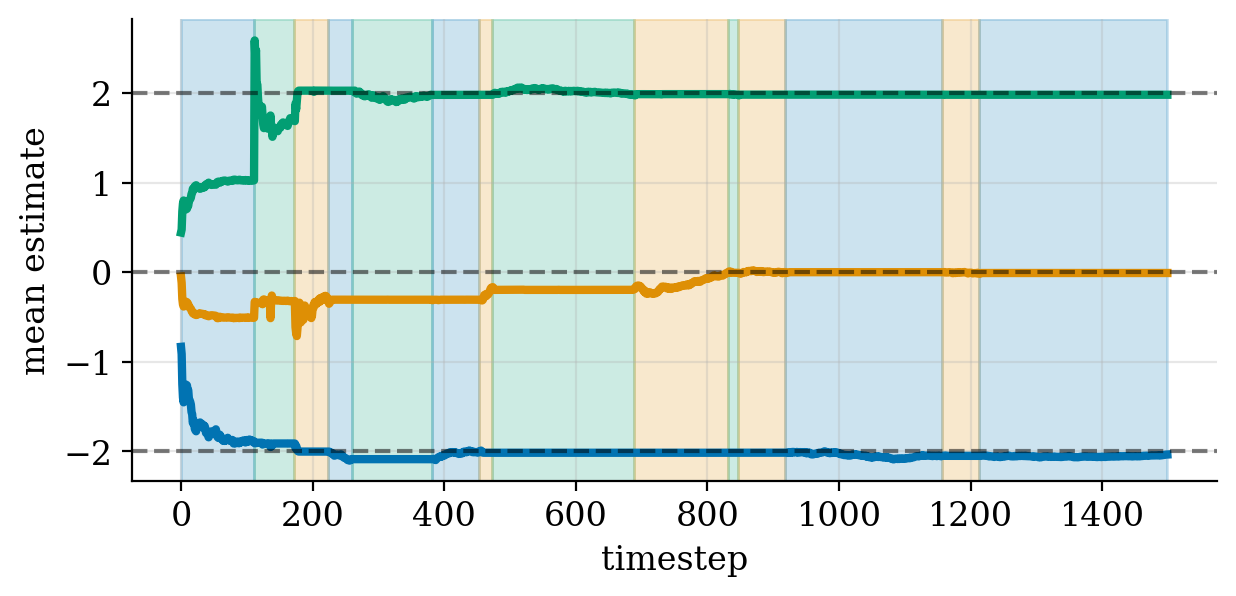

In [88]:
mean_est = jnp.einsum("ts,tsk...->tk", hist_weights, hist_mean)

plt.plot(mean_est[:, [2,0,1]], linewidth=3)

for iinit, iend in zip(regime_changes_ix[:-1], regime_changes_ix[1:]):
    plt.axvspan(iinit, iend, color=colors[states[iend]], alpha=0.2, linewidth=1)

for mean in means:
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.5)

plt.ylabel("mean estimate")
plt.xlabel("timestep")
# plt.xlim(0, 800)
plt.grid(alpha=0.3)
plt.savefig("./figures/hmm-mean-estimate.png", dpi=300, bbox_inches="tight")

In [73]:
hist_regimes_ohe = jax.nn.one_hot(bel_final.regime, n_regimes, axis=0)

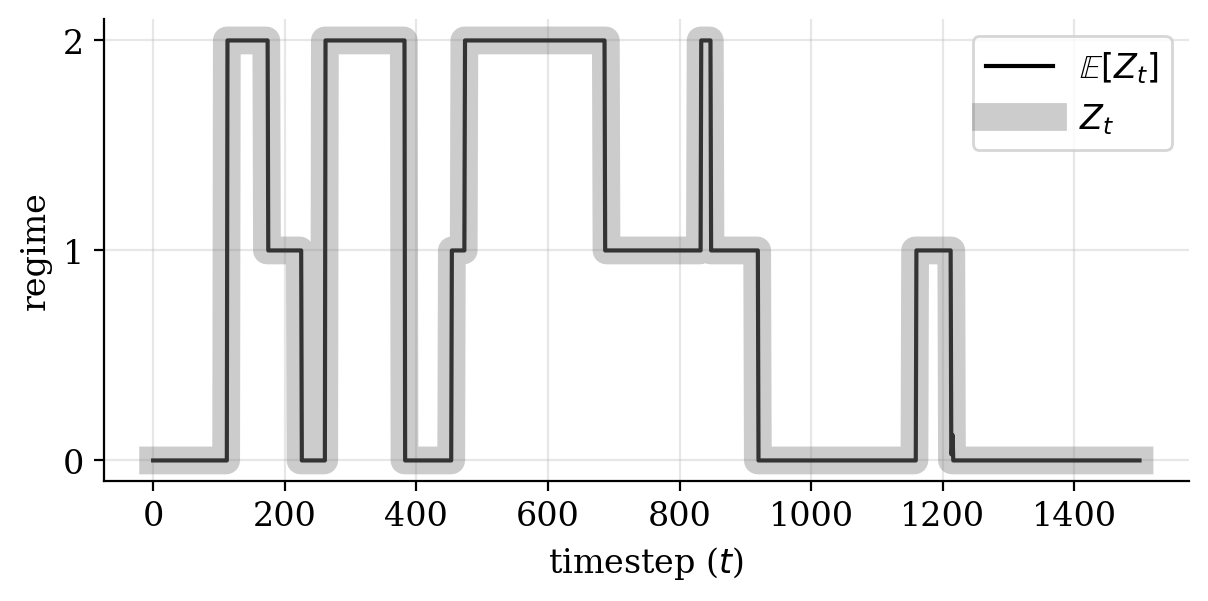

In [74]:
proba_regimes = jnp.einsum(
    "kst,ts->tk",
    hist_regimes_ohe[[2,0,1], ...],
    hist_weights
)
path_exp = jnp.einsum("tk,k->t", proba_regimes, jnp.arange(3))

plt.plot(path_exp, c="black", label=r"$\mathbb{E}[Z_t]$")
plt.plot(states, c="gray", linewidth=10, alpha=0.4, label="$Z_t$")
plt.legend()
plt.yticks([0, 1, 2])
plt.xlabel("timestep ($t$)")
plt.ylabel("regime")
plt.grid(alpha=0.3)

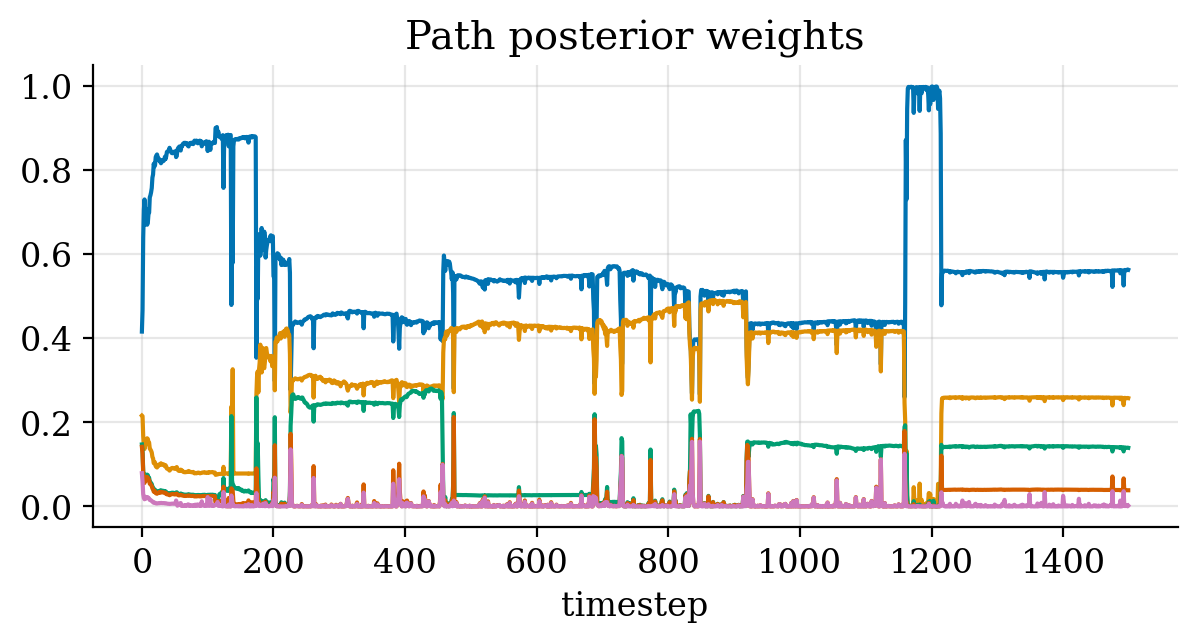

In [75]:
# Lower is better
plt.title("Path posterior weights")
plt.plot(hist_weights)
plt.xlabel("timestep")
plt.grid(alpha=0.3)

$$
    \hat{y}_t = \sum_{s=1}^S\sum_{k=1}^K m_{t,k}^{(s)}\;w_t^{(s)}
$$

In [76]:
pmean_est = jnp.einsum(
    "tsk...,kst,ts->t",
    hist_mean,
    hist_regimes_ohe,
    hist_weights
)

## Filtered estimates

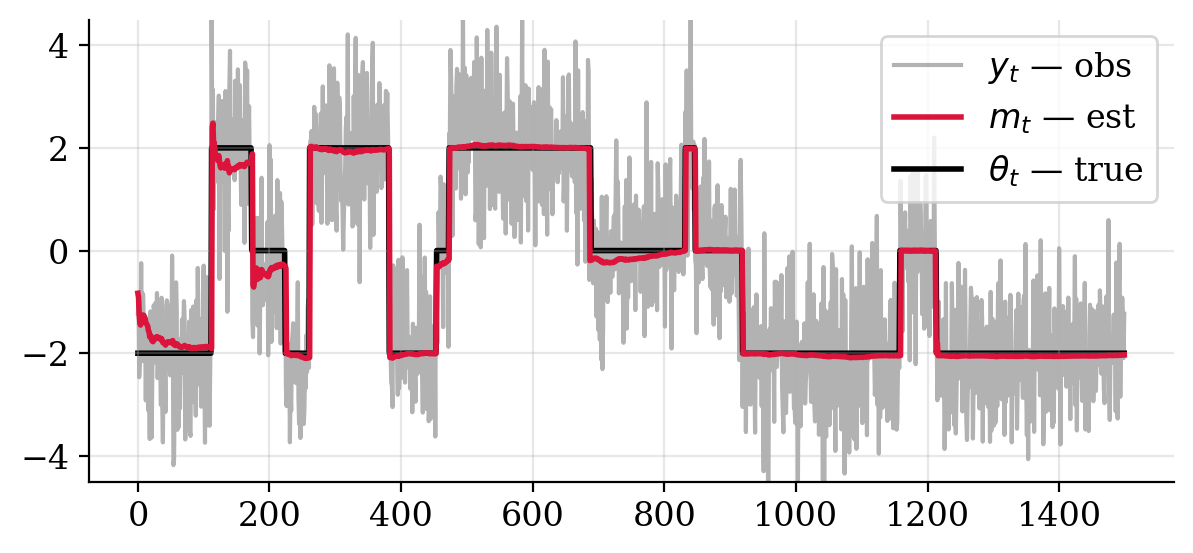

In [77]:
plt.plot(obs, c="gray", alpha=0.6, label="$y_t$ — obs", zorder=0)
plt.plot(pmean_est, c="crimson", linewidth=2, label="$m_t$ — est")
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=2, label=r"$\theta_t$ — true")
plt.legend()
plt.ylim(-4.5, 4.5)
plt.grid(alpha=0.3)
plt.savefig("./figures/hmm-estimation.png", dpi=300, bbox_inches="tight")

## Forecast estimates

In [78]:
lbound = hist_forecast["mean"] - 2 * hist_forecast["stdev_param"]
ubound = hist_forecast["mean"] + 2 * hist_forecast["stdev_param"]

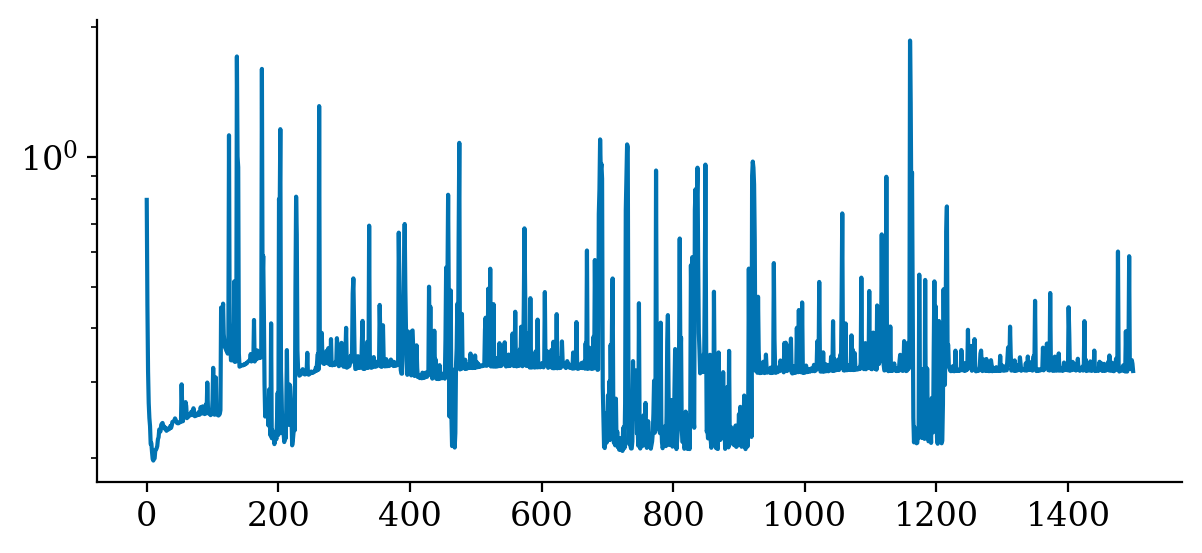

In [79]:
plt.plot(hist_forecast["stdev_param"])
plt.yscale("log")

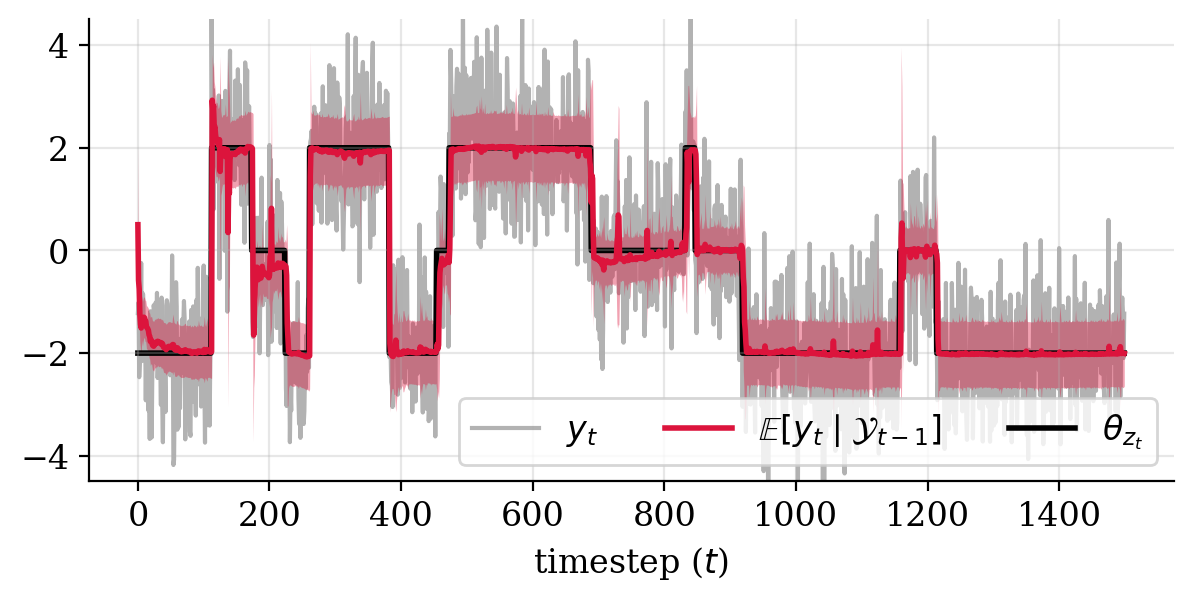

In [80]:
plt.fill_between(timesteps, lbound, ubound, color="crimson", alpha=0.4, linewidth=0)
plt.plot(obs, c="gray", alpha=0.6, label="$y_t$", zorder=0)
plt.plot(hist_forecast["mean"], c="crimson", linewidth=2, label=r"$\mathbb{E}[y_{t} \mid {\cal Y}_{t-1}]$")
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=2, label=r"$\theta_{z_t}$")
plt.legend(ncol=3, loc="lower right")
plt.ylim(-4.5, 4.5)
plt.grid(alpha=0.3)
plt.xlabel("timestep ($t$)")
plt.savefig("./figures/hmm-estimation.png", dpi=300, bbox_inches="tight")

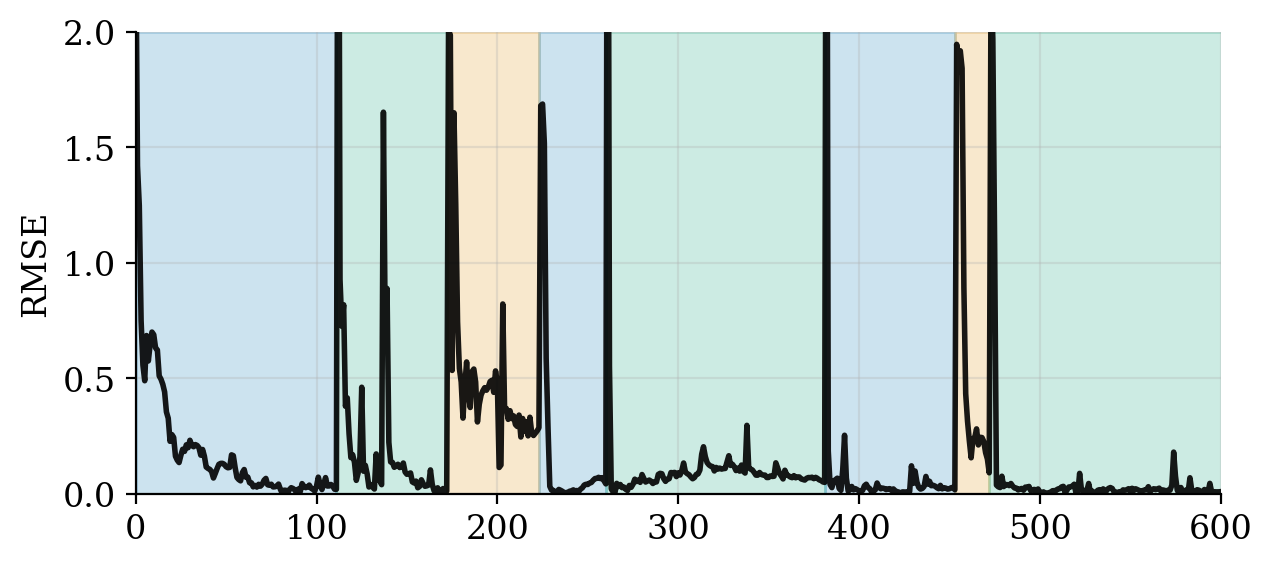

In [56]:
# Not much to do to prevent the spikes...
yhat = hist_forecast["mean"]
ytrue = means.at[states].get()

for iinit, iend in zip(regime_changes_ix[:-1], regime_changes_ix[1:]):
    plt.axvspan(iinit, iend, color=colors[states[iend]], alpha=0.2, linewidth=1)

diff_abs = jnp.abs(yhat - ytrue)
plt.plot(diff_abs, c="black", linewidth=2, alpha=0.9)
plt.ylim(0, 2)
# plt.xlim(0, n_steps)
plt.xlim(0, 600)
plt.ylabel("RMSE")
plt.grid(alpha=0.3)

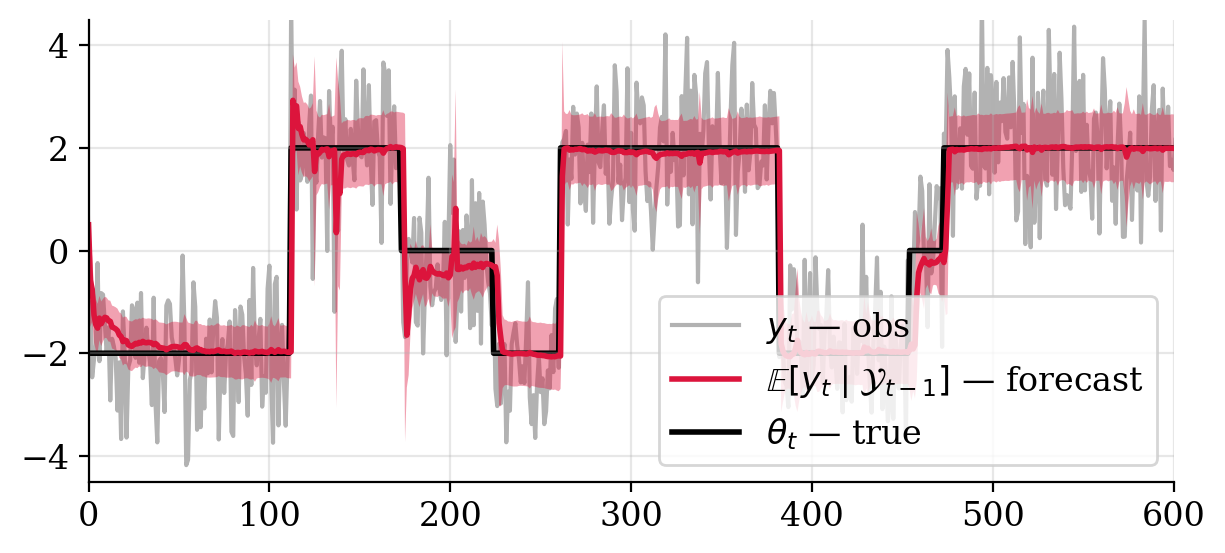

In [57]:
plt.fill_between(timesteps, lbound, ubound, color="crimson", alpha=0.4, linewidth=0)

plt.plot(obs, c="gray", alpha=0.6, label="$y_t$ — obs", zorder=0)
plt.plot(hist_forecast["mean"], c="crimson", linewidth=2, label=r"$\mathbb{E}[y_{t} \mid {\cal Y}_{t-1}]$ — forecast")
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=2, label=r"$\theta_t$ — true")

plt.legend()

plt.xlim(0, 600)
plt.ylim(-4.5, 4.5)
plt.grid(alpha=0.3)
plt.savefig("./figures/hmm-estimation.png", dpi=300, bbox_inches="tight")

Text(0.5, 0, 'timestep ($t$)')

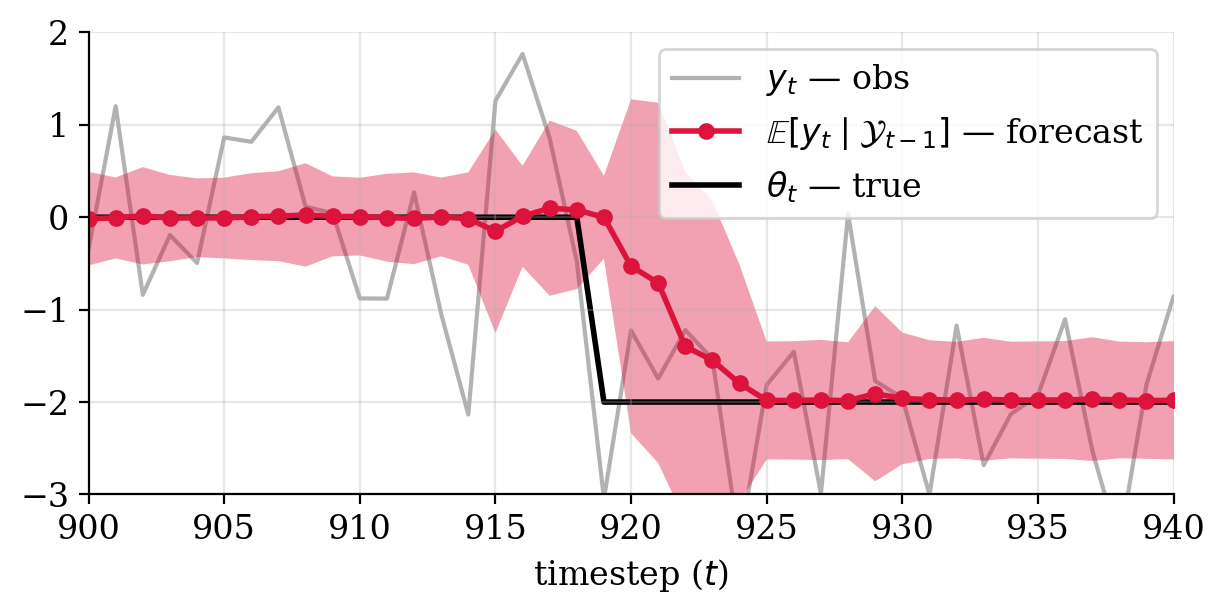

In [58]:
plt.fill_between(timesteps, lbound, ubound, color="crimson", alpha=0.4, linewidth=0)

label_mean = r"$\mathbb{E}[y_{t} \mid {\cal Y}_{t-1}]$ — forecast"
plt.plot(obs, c="gray", alpha=0.6, label="$y_t$ — obs", zorder=0)
plt.plot(hist_forecast["mean"], c="crimson", linewidth=2, label=label_mean, marker="o", markersize=5)
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=2, label=r"$\theta_t$ — true")

plt.legend()

plt.xlim(900, 940)
plt.ylim(-3, 2)
plt.grid(alpha=0.3)
plt.xlabel("timestep ($t$)")
# plt.savefig("./figures/hmm-estimation.png", dpi=300, bbox_inches="tight")

## Sequential Monte Carlo (SMC)

In [83]:
def update(y, regime, bel, cfg):
    """
    Update model parameters for a regime
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean # f(mean, x) — observation mean function
    
    err = y - yhat
    kt = var / (var + cfg.var_obs)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var_obs)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    # TOOD: replace vector regime for scalar regime
    timestep_new = bel.timestep + 1
    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[timestep_new.astype(int)].set(regime),
        timestep=timestep_new,
    )
    return bel, log_pp


def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices


def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold according to their log-weights
    """
    indices = multinomial_resampling(key, log_weights, n_particles)

    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.repeat(-jnp.log(n_particles), n_particles)
    )
    return bel



def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel


@partial(jax.vmap, in_axes=(0, None, 0, None))
def step_update(key, y, bel, cfg):
    """
    Sample regime and update
    """
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr]
    regime_next = jax.random.categorical(key, log_p_transition)

    bel_update, log_pp = update(y, regime_next, bel, cfg)

    return bel_update, log_pp


def step_sample(bel, xs, cfg):
    y, key = xs
    
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    
    bel_update, log_pp = step_update(keys, y, bel, cfg)
    log_weights = log_pp + bel.log_weight

    # Prediced mean
    weights_pred = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))

    # Update weights, compute the effective sample size
    ess = 1 / jnp.sum(weights_pred ** 2)

    ### Resample step ###
    bel_update = jax.lax.cond(
        ess < n_particles * 0.5,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    weights = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    mean_position = jnp.einsum("s...,s->...", bel.means, weights)
    

    return bel_update, (log_weights, mean_position, ess)

In [84]:
n_particles = 100
mean_init = jnp.array([0.0])
var_init = jnp.array([0.1]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(100, 3, 1), variances=(100, 3, 1), regime=(100, 1500), log_weight=(100,), timestep=(100,))

In [85]:
%%time
cfg = Cfg(var_obs=obs_var, num_particles=n_particles)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_sample, cfg=cfg)
bel_final, (hist_ll, hist_mean, hist_ess) = jax.lax.scan(_step, bel_init, Xs)
hist_mean = hist_mean.squeeze()
hist_ll = jax.block_until_ready(hist_ll)

CPU times: user 969 ms, sys: 55.6 ms, total: 1.02 s
Wall time: 292 ms


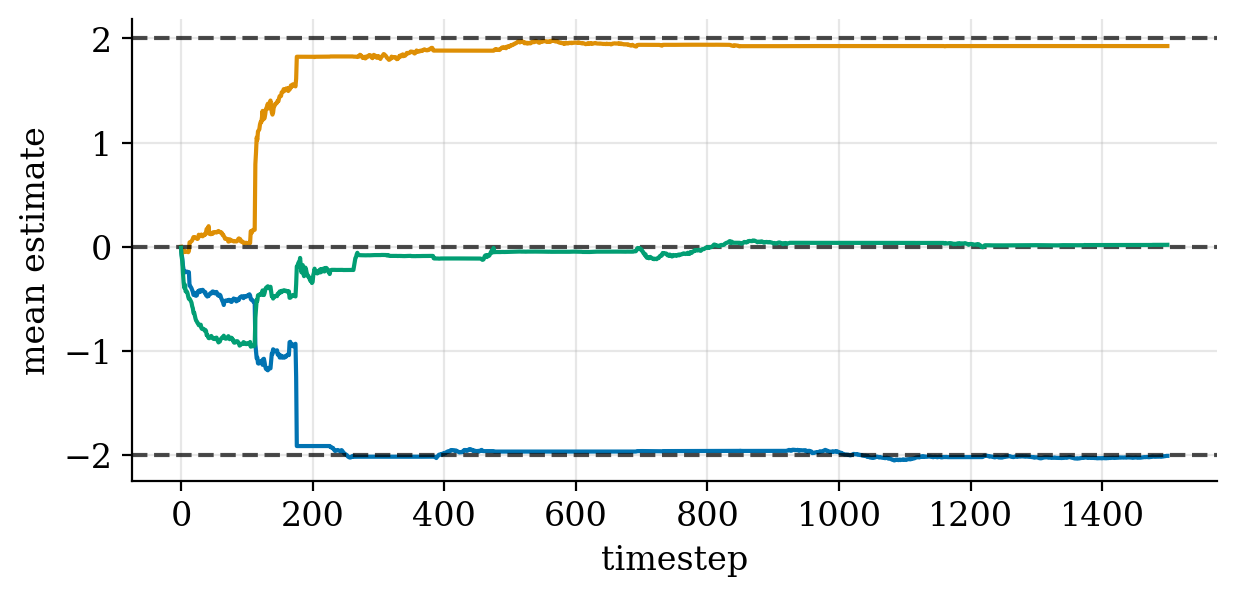

In [86]:
colors = sns.color_palette()
for i, mean in enumerate(means):
    mean_i = hist_mean[:, i]
    # std_i = hist_std[:, i]
    # lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.plot(timesteps, mean_i, c=colors[i])
    # plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.7)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

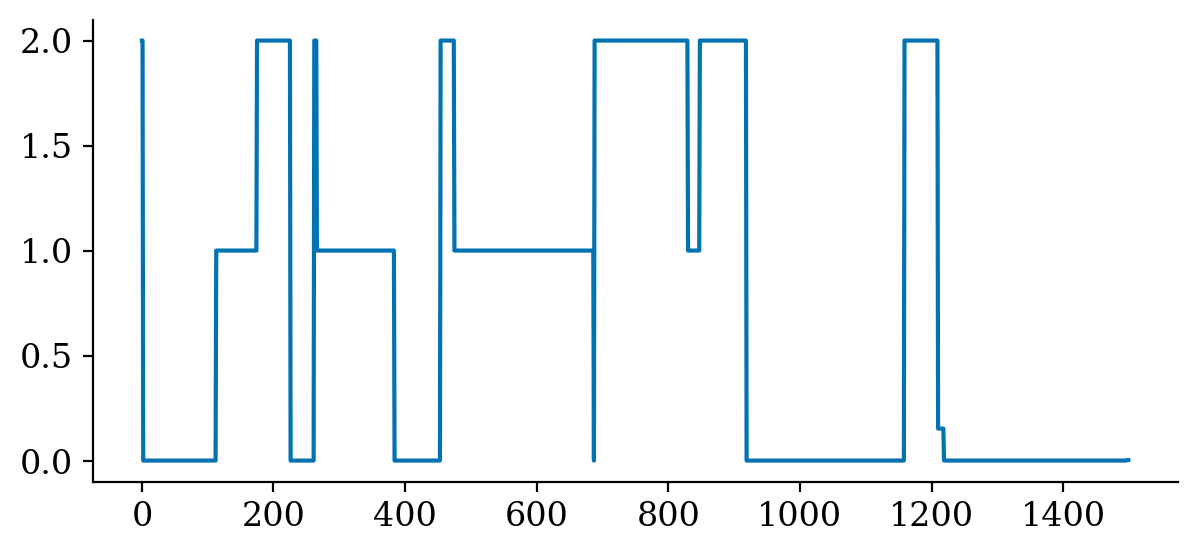

In [87]:
weights_final = jnp.exp(bel_final.log_weight - jax.nn.logsumexp(bel_final.log_weight))

plt.plot((bel_final.regime * weights_final[..., None]).sum(axis=0))

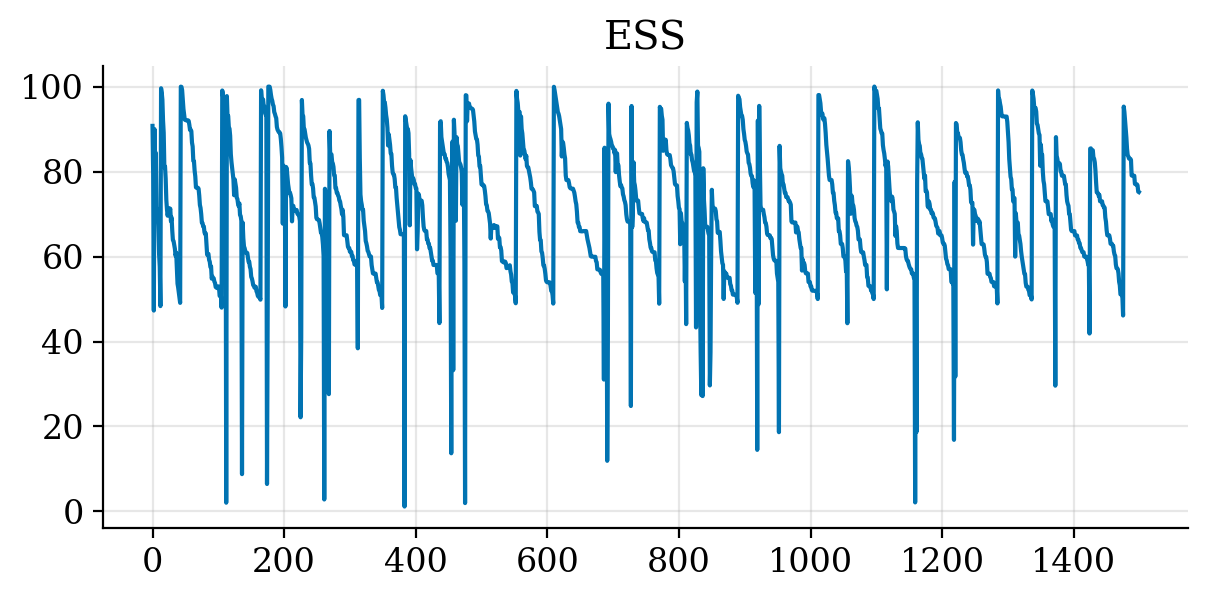

In [274]:
plt.plot(hist_ess)
plt.title("ESS")
plt.grid(alpha=0.3)

In [275]:
nll = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

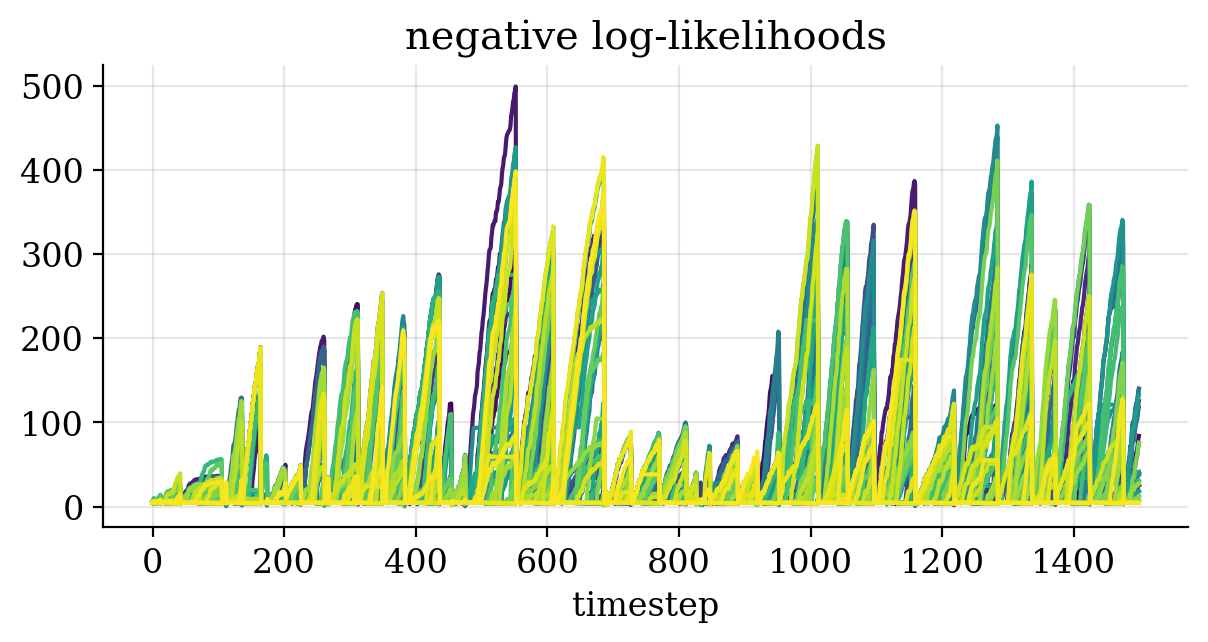

In [276]:
sns.lineplot(-nll, palette="viridis", legend=False, dashes=False)
plt.title("negative log-likelihoods")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

TypeError: mul got incompatible shapes for broadcasting: (1500, 3), (1500, 100).

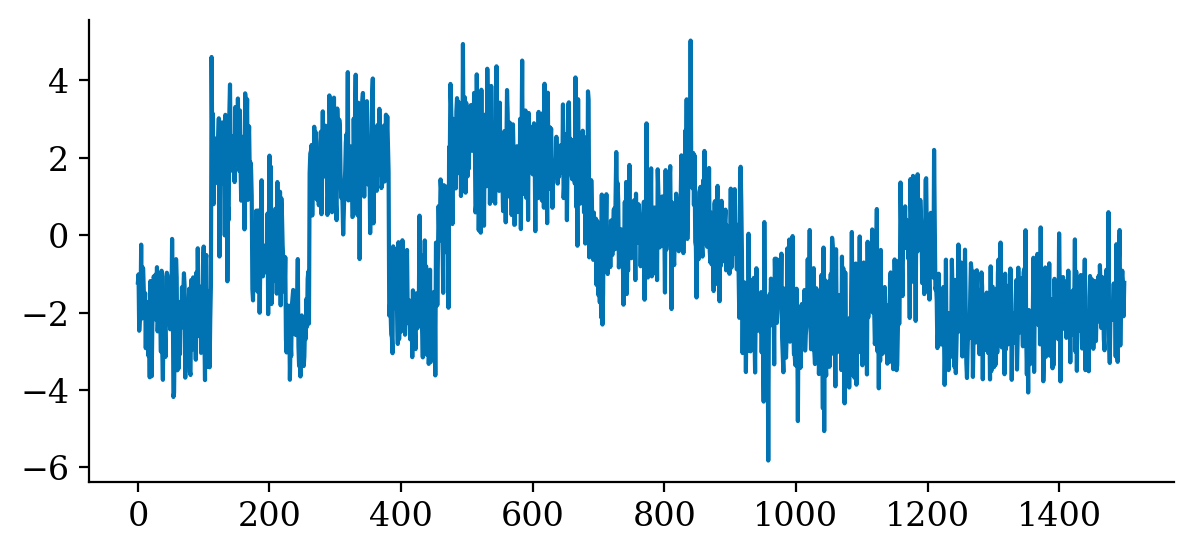

In [277]:
hist_ll_normed = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

plt.plot(obs)
plt.plot((hist_mean * jnp.exp(hist_ll_normed)).sum(axis=1), c="black")
plt.grid(alpha=0.3)

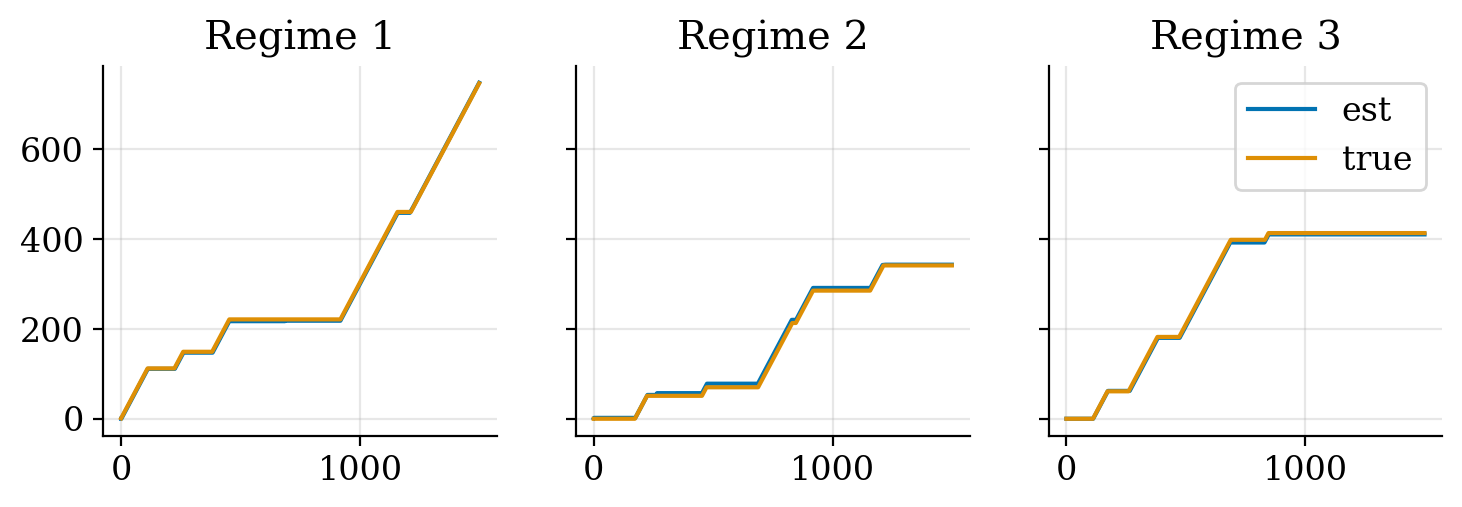

In [248]:
regimes_est_ohe = (jax.nn.one_hot(bel_final.regime.T, 3,) * weights_final[..., None]).sum(axis=1)
regimes_est_ohe = regimes_est_ohe[:, [0, 2, 1]] # Permutation is run-specific
regimes_est_count = regimes_est_ohe.cumsum(axis=0)
regimes_true_count = jax.nn.one_hot(states, 3).cumsum(axis=0)

ix = 0
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.2 * 1.2, 3.0 * 0.8))
for ix, ax in enumerate(axs):
    ax.plot(regimes_est_count[:, ix], label="est")
    ax.plot(regimes_true_count[:, ix], label="true")
    ax.set_title(f"Regime {ix+1}")
    ax.grid(alpha=0.3)
plt.legend()

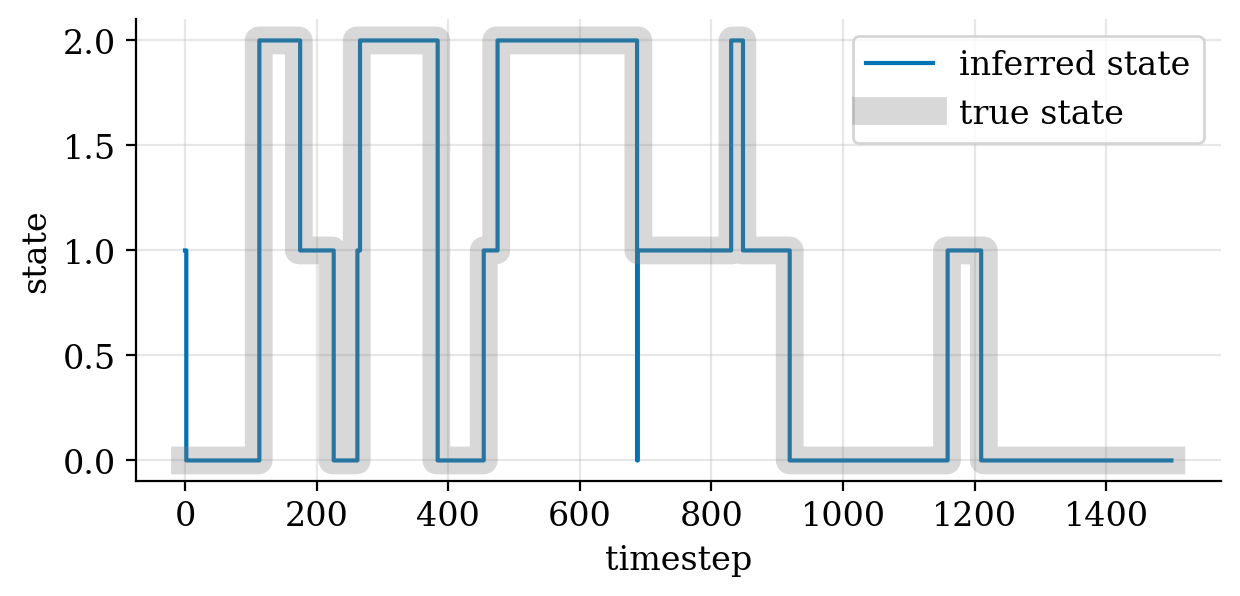

In [249]:
plt.step(timesteps, regimes_est_ohe.argmax(axis=1), label="inferred state", where="post")
plt.step(timesteps, states, label="true state", where="post", c="tab:gray", linewidth=10, alpha=0.3)
plt.ylabel("state")
plt.xlabel("timestep")
plt.legend()
plt.grid(alpha=0.3)